In [ ]:
import sys
!{sys.executable} -m pip install numpy pandas matplotlib scipy xarray geopandas netCDF4 cartopy

In [ ]:
# pp
# cdo -selyear,2000/2024 tg_data.nc tg_2000_2024.nc

In [1]:
import os, csv
from datetime import datetime
import netCDF4 as nc
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
import cartopy.crs as ccrs
from matplotlib.colors import Normalize

In [2]:
# precipitation partition using VIC model
# https://www.engr.scu.edu/~emaurer/chile/vic_taller/01_vic_training_overview_processes.pdf
t_rain_min = 0
t_snow_max = 2

def prec_part(T, P):
    sff = 0
    sf = 0
    
    if P > 0:
        if T <= t_rain_min:
            sff = 1   
        elif T >= t_snow_max:
            sff = 0   
        else:
            # linear interpolation y=-0.5t+1, slope=-0.5, intercept=1 
            sff = -0.5*T + 1
            
        # min and max cap
        if sff > 1: sff = 1
        if sff < 0: sff = 0
        
        sf = sff*P
        
    return float(sf), float(sff)

In [3]:
# vectorize to apply function to each pixel 
pp_vecfunc = np.vectorize(prec_part)

In [ ]:
1950-2024, 2000-2024 T, P winter -> SFF winter for SD, SRD classification

In [4]:
# EOBS nc file with DJF daily temperature data 
tds = xr.open_dataset('data/tg_ens_mean_0.1deg_reg_v30.0e.nc')
pds = xr.open_dataset('data/rr_ens_mean_0.1deg_reg_v30.0e.nc')

temp = xr.DataArray(tds['tg'])
prec = xr.DataArray(pds['rr'])
print('Temp shape', temp.shape)
print('Prec shape', prec.shape)

# sf, sff = pp_vecfunc(temp, prec)
# print('Daily Snow fall fraction shape 1950-2024', sff.shape, sf.shape)

Temp shape (27210, 465, 705)
Prec shape (27210, 465, 705)


In [ ]:
sf, sff = pp_vecfunc(temp, prec)
sf.shape

In [205]:
# EOBS nc file with DJF daily temperature data 
tds = xr.open_dataset('clim/t_winter_1950_2024.nc')
pds = xr.open_dataset('clim/p_winter_1950_2024.nc')

temp = xr.DataArray(tds['tg'])
prec = xr.DataArray(pds['rr'])
print('Temp shape', temp.shape)
print('Prec shape', prec.shape)

sf, sff = pp_vecfunc(temp, prec)
print('Daily Snow fall fraction shape 1950-2024', sff.shape, sf.shape)

Temp shape (75, 465, 705)
Prec shape (75, 465, 705)
Daily Snow fall fraction shape 1950-2024 (75, 465, 705) (75, 465, 705)


In [206]:
sff_da = xr.DataArray(sff, dims=("time", "latitude", "longitude"),
    coords={"time": tds["time"], "latitude": tds['latitude'], "longitude": tds['longitude']})
sff_da.to_netcdf('SD_SRD/sff_winter_1950_2024.nc')

In [224]:
# EOBS nc file with DJF daily temperature data 
tds = xr.open_dataset('clim/t_winter_2000_2024.nc')
pds = xr.open_dataset('clim/p_winter_2000_2024.nc')

temp = xr.DataArray(tds['tg'])
prec = xr.DataArray(pds['rr'])
print('Temp shape', temp.shape)
print('Prec shape', prec.shape)

sf1, sff1 = pp_vecfunc(temp, prec)
print('Daily Snow fall fraction shape 2000-2024', sf1.shape, sff1.shape)

Temp shape (25, 465, 705)
Prec shape (25, 465, 705)
Daily Snow fall fraction shape 2000-2024 (25, 465, 705) (25, 465, 705)


In [208]:
sff_da = xr.DataArray(sff1, dims=("time", "latitude", "longitude"),
    coords={"time": tds["time"], "latitude": tds['latitude'], "longitude": tds['longitude']})
sff_da.to_netcdf('SD_SRD/sff_winter_2000_2024.nc')

sff_da = xr.DataArray(sf1, dims=("time", "latitude", "longitude"),
    coords={"time": tds["time"], "latitude": tds['latitude'], "longitude": tds['longitude']})
sff_da.to_netcdf('SF/sf_winter_2000_2024.nc')


In [225]:
# EOBS nc file with DJF daily temperature data 
tds = xr.open_dataset('clim/t_spring_2000_2024.nc')
pds = xr.open_dataset('clim/p_spring_2000_2024.nc')

temp = xr.DataArray(tds['tg'])
prec = xr.DataArray(pds['rr'])
print('Temp shape', temp.shape)
print('Prec shape', prec.shape)

sf2, sff2 = pp_vecfunc(temp, prec)
print('Daily Snow fall fraction shape 2000-2024', sf1.shape, sff1.shape)

Temp shape (25, 465, 705)
Prec shape (25, 465, 705)
Daily Snow fall fraction shape 2000-2024 (25, 465, 705) (25, 465, 705)


In [211]:
sff_da = xr.DataArray(sf2, dims=("time", "latitude", "longitude"),
    coords={"time": tds["time"], "latitude": tds['latitude'], "longitude": tds['longitude']})
sff_da.to_netcdf('SF/sf_spring_2000_2024.nc')

In [ ]:
# remove ocean pixel using mask - CDO
# cdo remapbil,sf_winter_2000_2024.nc data/ERA5_land_sea_mask.nc regridded_land_mask.nc
# cdo mul sf_winter_2000_2024.nc regridded_land_mask.nc sf_land_only.nc
# cdo setctomiss,0 sf_land_only.nc sf_land_only_nan.nc

In [226]:
# classify snow dominated, snow-rain dominated pixels
def classify_sd_srd(sff):
    if sff>=0.5:
        return 1 # SD
    elif sff>0 and sff<0.5:
        return 0.5 # SRD
    return sff # RD

sff_vecfunc = np.vectorize(classify_sd_srd)

In [227]:
sd_srd = sff_vecfunc(sff)
sd_srd1 = sff_vecfunc(sff1)
print('Snow dom, snow rain dom', sd_srd.shape, sd_srd1.shape)

Snow dom, snow rain dom (75, 465, 705) (25, 465, 705)


In [228]:
sd_srd = np.mean(sd_srd, axis=0)
sd_srd1 = np.mean(sd_srd1, axis=0)
print('Snow dom, snow rain dom', sd_srd.shape, sd_srd1.shape)

Snow dom, snow rain dom (465, 705) (465, 705)


In [233]:
sff_da = xr.DataArray(sd_srd, dims=("latitude", "longitude"),
    coords={"latitude": tds['latitude'], "longitude": tds['longitude']})

# Save the DataArray to a NetCDF file
sff_da.to_netcdf('SD_SRD/sd_srd_1950_2024.nc') 

sff_da = xr.DataArray(sd_srd1, dims=("latitude", "longitude"),
    coords={"latitude": tds['latitude'], "longitude": tds['longitude']})

# Save the DataArray to a NetCDF file
sff_da.to_netcdf('SD_SRD/sd_srd_2000_2024.nc') 

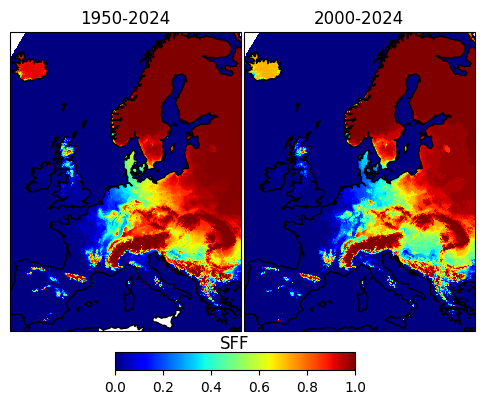

In [251]:
lats = tds['latitude']
lons = tds['longitude']
lons, lats = np.meshgrid(lons, lats)

min_lat = 35
max_lat = 71
min_lon = -8
max_lon = 25
clon = (min_lon + max_lon) / 2
clat = (min_lat + max_lat) / 2
europe_bbox = [min_lon, max_lon, min_lat, max_lat]

fig, axs = plt.subplots(1,2, figsize=(6,6), subplot_kw={'projection': ccrs.Orthographic(central_latitude=clat, central_longitude=clon)})
ax1 = axs[0]
ax2 = axs[1]
ax1.set_extent(europe_bbox, crs=ccrs.PlateCarree())
ax2.set_extent(europe_bbox, crs=ccrs.PlateCarree())
ax1.set_title('1950-2024', fontsize=12)
ax2.set_title('2000-2024', fontsize=12)
ax1.coastlines()
ax2.coastlines()

c1 = ax1.pcolormesh(lons, lats, sd_srd, cmap="jet", transform=ccrs.PlateCarree())
c2 = ax2.pcolormesh(lons, lats, sd_srd1, cmap="jet", transform=ccrs.PlateCarree())

sm = ScalarMappable(cmap='jet', norm=Normalize(vmin=0.0, vmax=1.0))  # Updated vmax to 0.7
sm.set_array([])
cax = fig.add_axes([0.3, 0.18, 0.4, 0.03])  # [left, bottom, width, height] 
cbar = fig.colorbar(sm, cax=cax, orientation='horizontal')

cbar.ax.tick_params(labelsize=10)  # Adjust tick size
cbar.ax.text(0.5, 1.5, 'SFF', fontsize=12, ha='center', va='center', transform=cbar.ax.transAxes)
fig.subplots_adjust(wspace=0.01, hspace=0)
plt.show()



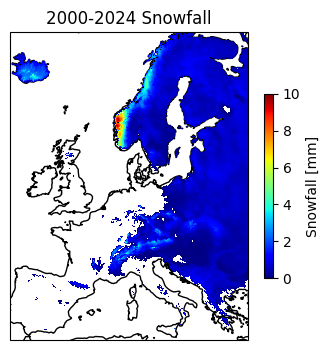

In [252]:
sfds = xr.open_dataset('SF/sf_winter_2000_2024.nc')  # Replace with your file path
lats = sfds['latitude']
lons = sfds['longitude']
sf = sfds['__xarray_dataarray_variable__'][0,:,:]
# sf = sf.mean(axis=0)

# Convert lons and lats to meshgrid
lons, lats = np.meshgrid(lons, lats)

# Define plot extent and center
min_lat, max_lat = 35, 71
min_lon, max_lon = -8, 25
clon, clat = (min_lon + max_lon) / 2, (min_lat + max_lat) / 2
europe_bbox = [min_lon, max_lon, min_lat, max_lat]

# Create the figure and axis
fig, ax = plt.subplots(
    figsize=(4, 4), subplot_kw={'projection': ccrs.Orthographic(central_latitude=clat, central_longitude=clon)}
)
ax.set_extent(europe_bbox, crs=ccrs.PlateCarree())
ax.set_title('2000-2024 Snowfall', fontsize=12)

# Add coastlines
ax.coastlines()

# Add land as a filled feature with facecolor for land and leave the ocean as white
land_feature = cfeature.NaturalEarthFeature(
    category='physical', name='land', scale='50m', facecolor='white'
)
ax.add_feature(land_feature, zorder=1)

# Plot the snowfall data
c1 = ax.pcolormesh(lons, lats, sf, cmap="jet", transform=ccrs.PlateCarree(), zorder=2)

# Add colorbar
sm = ScalarMappable(cmap='jet', norm=Normalize(vmin=0, vmax=10))
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', shrink=0.6, label='Snowfall [mm]')
cbar.ax.tick_params(labelsize=10)

fig.subplots_adjust(wspace=0.01, hspace=0)
plt.show()

In [2]:
# Kopen-Geiger climate classification
# https://www.nature.com/articles/sdata2018214
# class C - temperate, D - cold/subpolar in EU in ratio of 50:30:20 [cold, subpolar, temperate]

# run scripts - mask out sff
####### classificaiton based on https://www.nature.com/articles/nclimate2246
##### count SD, SRD of 1950-2024
sff_file = 'SD_SRD/sff_winter_19s.csv'
sff = pd.read_csv(sff_file)
# sff = sff.drop(columns=['Mean', 'Class'])

# find average over 1950-2024 and classify
# sff["Mean"] = sff.iloc[:, 3:].mean(axis=1)
# # if sff > 0.5, SD, sff > 0 and <0.5, SRD, remaining RD
# sff["Class"] = sff["Mean"].apply(lambda x: "SD" if x >= 0.5 else "SRD")
# sff.loc[sff["Mean"] == 0, "Class"] = "RD"
# sff = sff.dropna(subset=['Mean', 'Class'])
# sff.to_csv(sff_file, index=False)

river_counts = sff.groupby('Class')['RIVERBASIN'].nunique()
print("Number of rivers by class during 1950-2024:", river_counts)

##### count SD, SRD of 2000-2024
sff_file1 = 'SD_SRD/sff_winter_2k.csv'
sff1 = pd.read_csv(sff_file1)
# sff1 = sff1.drop(columns=['Mean', 'Class'])

# find average over 2000-2024 and classify
# sff1["Mean"] = sff1.iloc[:, 3:].mean(axis=1)
# sff1["Class"] = sff1["Mean"].apply(lambda x: "SD" if x >= 0.5 else "SRD")
# sff1.loc[sff1["Mean"] == 0, "Class"] = "RD"
# # sff1 = sff1.dropna(subset=['Mean', 'Class'])
# sff1.to_csv(sff_file1, index=False)

river_counts = sff1.groupby('Class')['RIVERBASIN'].nunique()
print("Number of rivers by class during 2000-2024:", river_counts)

Number of rivers by class during 1950-2024: Class
RD      2
SD     59
SRD    16
Name: RIVERBASIN, dtype: int64
Number of rivers by class during 2000-2024: Class
RD      3
SD     55
SRD    19
Name: RIVERBASIN, dtype: int64


In [ ]:
Out of 77 river basins, 2 basins are totally rain-dominated. Out of remaining 75, 59 were snow-dominated 
and 16 were both snow-rain-dominated during the climatological period of 1950-2024. In the climatological 
period of 2000-2024, snow-dominated basins have reduced to 55 while snow-rain-dominated increased to 19. 
This shows the 4 basins (Gudena, Skjerna, Spey, Weser) transitioned from SD to SRD, has received less 
snowfall and 1 basin (Guadiana) transitioned from SRD to RD, receiving no snowfall.

71% of the basins in the Europe receive more than half of their precipitation as snow, thus snow-dominated. 

In [3]:
# finding rivers which were SD during 1950-2024 became SRD during 2000-2024
sd = sff[sff["Class"] == "SD"]
srd1 = sff1[sff1["Class"] == "SRD"]
transition_rivers = pd.merge( sd[["RIVERBASIN"]], srd1[["RIVERBASIN"]], on="RIVERBASIN")
print(transition_rivers)

  RIVERBASIN
0     GUDENA
1   SKJERN A
2       SPEY
3      WESER


In [4]:
# finding rivers which were SRD during 1950-2024 became RD during 2000-2024
srd = sff[sff["Class"] == "SRD"]
rd1 = sff1[sff1["Class"] == "RD"]
transition_rivers = pd.merge( srd[["RIVERBASIN"]], rd1[["RIVERBASIN"]], on="RIVERBASIN")
print(transition_rivers)

  RIVERBASIN
0   GUADIANA
